<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/2_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/train_transaction.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/train_identity.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/original_data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col_mice.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/cat_sign_col.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted_old/fitted.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted_old/cat_sign_col.txt
/content/drive/MyDrive/Tesi_magistral

In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

In [3]:
original_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/original_data.csv')
original_data.drop(original_data.columns[original_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [4]:
numerical_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted.csv')
numerical_data.drop(numerical_data.columns[numerical_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

## Dataset split in numerical e categorical

Seleziono le feature i cui dati sono numerici. 

https://pandas.pydata.org/pandas--docs/stable/reference/api/pandas.DataFrame.select_dtypes.html

In [5]:
num_data = numerical_data.drop(['isFraud','TransactionID','TransactionDT'], axis = 1)

In [6]:
numerical_cols = original_data.select_dtypes(include=['int64','float64']).columns

In [7]:
categorical_col = []
categorical_col.append('TransactionID')
categorical_col.append('isFraud')
for col in original_data:
  if col not in numerical_cols:
    categorical_col.append(col)

len(categorical_col)
categorical_data = original_data[original_data.columns.intersection(categorical_col)]

# Exploratory analysis


Vedo su quanti giorni va il dataset e controllo la proporzione tra eventi fraudolenti e non. 

In [8]:
total_days = np.ceil(max(original_data['TransactionDT'])/(86400))
print('Dataset spans ', total_days, ' days')

fraud = (original_data['isFraud'] == 1).sum()
safe = (original_data['isFraud'] == 0).sum()
print('Fraudolent events: ', fraud)
print('Safe events: ', safe)
print('Ratio Fraud/safe: ', fraud/(fraud + safe))

Dataset spans  183.0  days
Fraudolent events:  20663
Safe events:  569877
Ratio Fraud/safe:  0.03499000914417313


## Analisi feature numeriche

Analizzo la distribuzione e la significatività statistica delle feature numeriche. 

Boxplot per confrontare la distribuzione delle feature numeriche tra transazioni fraudolente e non. 

Riferimento: https://stackoverflow.com/questions/62166292/seaborn-catplot-is-throwing-error-truth-value-is-ambiguous

Riferimento map_dataframe: https://stackoverflow.com/questions/35131798/tweaking-seaborn-boxplot

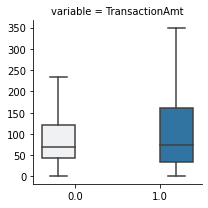

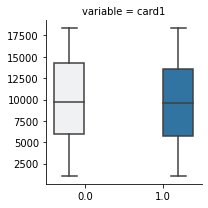

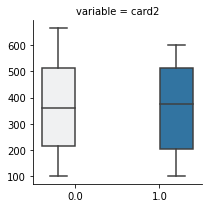

In [9]:
melted = []
n_plot = 3 # len(cat_cols)
target_col = "isFraud"
cat_cols = num_data.columns[(num_data.dtypes == int) | (num_data.dtypes == float)]
for i in range(n_plot):
    melted.append(numerical_data.melt(id_vars=target_col,value_vars=cat_cols[i]))
    g = sns.FacetGrid(melted[i], col='variable', sharex=False,col_wrap=1)
    g.map_dataframe(sns.boxplot, x="isFraud", y="value", showfliers=False, hue = 'isFraud')
    plt.show()

Visualizzo la differenza nella distribuzione di probabilità della feature a seconda della label. 

Documentazione histplot: https://seaborn.pydata.org/generated/seaborn.histplot.html

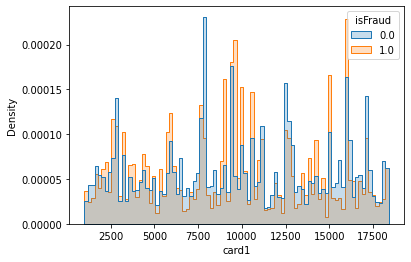

In [10]:
sns.histplot(data=numerical_data[['card1','isFraud']], x="card1", hue="isFraud", element="step", stat="density", common_norm=False)

Calcolo le medie e le deviazioni standard per poter calcolare la variabile t ed effettuare il test di Welch.

In [11]:
means = mf.get_stat(numerical_data, mean=True)
stds = mf.get_stat(numerical_data, std=True)

In [12]:
safe_numerical = mf.get_subFrame(numerical_data, safe = True)
fraud_numerical = mf.get_subFrame(numerical_data, fraud = True)

Definisco le funzioni per poter effettuare il Welch test e lo effettuo. 

$ t = \frac{\mu_{0} - \mu_{1}}{\sqrt{\frac{s_{0}^{2}}{N_{0}} + \frac{s_{1}^{2}}{N_{1}}}}$

$ \nu = \frac{(\frac{s_{0}^{2}}{N_{0}} + \frac{s_{1}^{2}}{N_{1}})^{2}}{{\frac{s_{0}^{4}}{N_{0}^{2}\nu_{0}} + \frac{s_{1}^{4}}{N_{1}^{2}\nu_{1}}}}$
 

`t` e `dof` sono due dizionari. `t` contiene i valori della variabile t, e `dof` i gradi di libertà. 

Riferimento wikipedia Welch t-test:  https://en.wikipedia.org/wiki/Welch%27s_t-test

In [13]:
t_variable = mf.t(means, stds, safe_numerical, fraud_numerical)
dof = mf.v(safe_numerical, fraud_numerical, stds)

Una volta effettuato il test, scelgo il livello di significatività e vado a selezionare le feature con p-value superiore a tale livello. 

Calcolo del p-value: https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f

`num_sign_col`: lista con le colonne numeriche significative tramite test di Welch e con missing values rimpiazzati tramite MICE. 

Riferimento scrittura file testo: https://stackoverflow.com/questions/899103/writing-a-list-to-a-file-with-python

Riferimento lettura file testo: https://www.kite.com/python/answers/how-to-read-a-text-file-into-a-list-in-python



In [14]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col_mice.txt'):
    num_sign_col = sig_cols(t_variable, safe_numerical)
    with open('num_sign_col_mice.txt', 'w') as f:
        for item in num_sign_col:
            f.write("%s " % item)
            
file = open("/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col_mice.txt", "r")
num_sign_col = file.read()
num_sign_col = num_sign_col.split(" ")
file.close()
num_sign_col.pop()
len(num_sign_col)

118

## Analisi feature categoriche
Analizzo il comportamento delle feature categoriche. 

Istogrammi delle feature categoriche. 

In [15]:
done = False
if done:
  for col in categorical_col[3:10]:
      ax = sns.catplot(data = categorical_data, x=col, hue='isFraud', kind = 'count')
      ax.set(yscale="log")
      plt.show()

Inizializzo i dizionari che conterranno i conteggi e le frequenze relative a ciascuna feature. Inoltre elimino le colonne isFraud e TransactionID. 

In [16]:
count = {}
frequencies = {}
done = False
if not done:
    categorical_col.remove('isFraud')
    categorical_col.remove('TransactionID')
    done = True

Riferimento `group_by`: https://stackoverflow.com/questions/42563209/how-to-count-subgroups-of-categorical-data-in-a-pandas-dataframe


In [17]:
for col in categorical_col:
    count[col] = categorical_data.groupby('isFraud')[col].value_counts().unstack(fill_value=0)
    frequencies[col] = categorical_data.groupby('isFraud')[col].value_counts(normalize = True).unstack(fill_value=0)    
#     print(frequencies[col], '\n')

## Test $\chi^2$
Importo la funzione `chi2_contingency` che permette di effettuare il test $\chi^2$. 

$H_{0}$: le differenze tra le frequenze nel caso di transazioni fraudolente e non, non siano statisticamente significative, cioè che siano il frutto di noise nel dataset. 

Risultato: Se il p-value è inferiore al livello di significatività del test, allora la differenza tra le frequenze è significativa, cioè non è casuale. 

Riferimenti `chi2_contingency`: 

* https://www.geeksforgeeks.org/python-pearsons-chi-square-test/

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html

`cat_sign_col`: lista che contiene il nome delle colonne, con variabili categorihe, significative tramite test $\chi^{2}$. 

In [18]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/cat_sign_col.txt'):
    cat_sign_col = mf.get_sign_cols(count)
    with open('cat_sign_col.txt', 'w') as f:
        for item in cat_sign_col:
            f.write("%s " % item)
            
file = open("/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/cat_sign_col.txt", "r")
cat_sign_col = file.read() # importo il file
cat_sign_col = cat_sign_col.split(" ") # le colonne sono separate dallo spazio
file.close() 
cat_sign_col.pop() # levo l'ultimo elemento che è vuoto

''

In [19]:
print(len(cat_sign_col), ' significative features on', len(categorical_col), ' total features')

30  significative features on 31  total features


## Analisi delle correlazioni

#### Funzioni:

* `dropColNotSign(dataset, col_sign, not_ignore = None)`: funzione per eliminare le colonne non significative dal dataset. `not_ignore`: colonna da ritenere significativa anche se non presente nella lista `col_sign`. 

* `corr_matrix_plot(dataset, corr_matrix)`: funzione per plottare la matrice di correlazione. 

* `highest_correlations(corr_matrix, tresh = 0.8)`: restituisce le features con correlazione superiore alla soglia `tresh` specificata.

* `corr_dict(corr)`: restituisce un dizionario i cui elementi sono le coppie di features correlate, con relativo valore di correlazione. 

#### Variabili: 

`col_sign` è una lista che conterrà le colonne significative, cioè quelle selezionate per portare avanti l'analisi. 

`corr_d`: dizionario con le coppie di features correlate e relativa correlazione. 

#### Riferimenti 

* Riferimento sul sort: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

- Riferimento `drop_duplicates`: https://stackoverflow.com/questions/30530663/how-to-select-distinct-across-multiple-data-frame-columns-in-pandas

* Riferimento `corr_sorted[corr_sorted>tresh]`: https://stackoverflow.com/questions/32067054/remove-rows-of-zeros-from-a-pandas-series

* Riferimento `corr_dict`: https://stackoverflow.com/questions/25929319/how-to-iterate-over-pandas-multiindex-dataframe-using-index

* Riferimento `np.isnan`: https://numpy.org/doc/stable/reference/generated/numpy.isnan.html

In [20]:
col_sign = num_sign_col + cat_sign_col # lista con le features significative
print('Number of significative features: ', len(col_sign))
correlation_data = mf.dropColNotSign(numerical_data, num_sign_col) # dataset solo con le features significative
correlation_data_fraud = mf.dropColNotSign(numerical_data, num_sign_col, not_ignore = 'isFraud') 
correlation_data_fraud = correlation_data_fraud[correlation_data_fraud['isFraud'] == 1 ]

Number of significative features:  148


In [21]:
show_plots = False
if show_plots:
  corr_matrix = correlation_data.corr()
  mf.corr_matrix_plot(correlation_data, corr_matrix)
  highest_corr = mf.highest_correlations(corr_matrix)
  highest_corr= highest_corr.unstack(level = 1)

  corr_matrix_fraud = correlation_data_fraud.corr()
  mf.corr_matrix_plot(correlation_data_fraud, corr_matrix_fraud)
  highest_corr_fraud = mf.highest_correlations(corr_matrix_fraud)
  highest_corr_fraud = highest_corr_fraud.unstack(level = 1)

  corr_d, corr_list = mf.corr_dict(highest_corr)
  corr_d_fraud, corr_list_fraud = mf.corr_dict(highest_corr_fraud)

Vado ad individuare le correlazioni che ci sono solo nel caso di transazioni fraudolente. 

In [22]:
if show_plots:
  unique_corr = []
  for item in corr_list_fraud:
      if item not in corr_list:
        unique_corr.append(item)

Fare differenza delle correlazioni nel caso fraud e safe per vedere se spuntano correlazioni diverse. 

Riferimento `scatterplot`: https://seaborn.pydata.org/generated/seaborn.scatterplot.html

In [23]:
done = False
if done:
  for item in unique_corr:
    sns.scatterplot(data=correlation_data[item], x=item[0], y=item[1])
    plt.show()